In [1]:
import numpy as np

import torch
from transformers import *

class relationEmbeddings:
    def __init__(self, tokenizer, model):
        self._tokenizer = tokenizer.from_pretrained('roberta-base')
        self._model = model.from_pretrained('roberta-base', output_hidden_states = True).cuda(0)
        self._model.eval()
        
    def tokenize(self, sentence):
        marked_sentence = '<s> ' + sentence + ' </s>'
        tokenized_text = self._tokenizer.tokenize(marked_sentence)
        return tokenized_text
    
    def get_embeddings(self, sentence):
        tokenized_text = self.tokenize(sentence)
        indexed_tokens = self._tokenizer.convert_tokens_to_ids(tokenized_text)
        segment_ids = [1]*len(tokenized_text)
        
        #Convert to tensor
        tokens_tensor = torch.tensor([indexed_tokens]).cuda(0)
        segment_tensors = torch.tensor([segment_ids]).cuda(0)
        
        with torch.no_grad():
            encoded_layers = self._model(tokens_tensor, segment_tensors)
            
        return encoded_layers[-1][0:12]
    
    def sentence2vec(self, sentence):
        '''
        Returns concatenated hidden dimensions
        '''
        encoded_layers = self.get_embeddings(sentence)
        token_embeddings = []
        tokenized_text = self.tokenize(sentence)
        #What is is batch? The number of sentences passed
        batch_i = 0
        for token_i in range(len(tokenized_text)):
            hidden_layers = []
            for layer_i in range(len(encoded_layers)):
                vec = encoded_layers[layer_i][batch_i][token_i]
                hidden_layers.append(list(vec.cpu().detach().numpy()))
                
            token_embeddings.append(hidden_layers)
            
        #Concatenate embeddings
        token_vecs_concat = []
        for token in token_embeddings:
            concat_embeddings = np.concatenate(token[-4:], axis=0)
            token_vecs_concat.append(list(concat_embeddings))
            return token_vecs_concat#.ravel().tolist()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
print(torch.cuda.get_device_name(0))
re = relationEmbeddings(RobertaTokenizer, RobertaModel)

GeForce GTX 1080 Ti


In [3]:
import rel_ext
import utils
import os

utils.fix_random_seeds()
rel_ext_data_home = os.path.join('data', 'rel_ext_data')

corpus = rel_ext.Corpus(os.path.join(rel_ext_data_home, 'corpus.tsv.gz'))
kb = rel_ext.KB(os.path.join(rel_ext_data_home, 'kb.tsv.gz'))

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

### Generate representation for adjoins

def _get_tuples_for_relation(relation:str):
    return list(map(lambda x:(x.sbj, x.obj), kb.get_triples_for_relation(relation)))

def _get_text_for_examples(corpus_example):
    return corpus_example.middle

def _get_examples_for_relation(list_entities:list):
    all_relations_examples = {}
    for entities in list_entities:
        examples = corpus.get_examples_for_entities(entities[0], entities[1])
        if len(corpus.get_examples_for_entities(entities[0], entities[1])) > 0:
            all_relations_examples[str(entities)] = list(map(lambda x:_get_text_for_examples(x), corpus.get_examples_for_entities(entities[0], entities[1])))
        else:
            continue         
    return all_relations_examples

#Uses np.mean just to keep dimensions
def _get_bert_representations(dict_entities: dict, sentence2vecFn):
    entities_representations = {}
    for entities in dict_entities:
        bert_representations = []
        for example in dict_entities[entities]:
            try:
                rep = sentence2vecFn(example)
            except:
                continue
            bert_representations.append(rep)
            
        entities_representations[entities] = np.mean(bert_representations, axis=0)
        
    return entities_representations         

#Wrapper for obtaining text for relations
def get_text_for_relation(relation:str):
    tuples_in_relation = _get_tuples_for_relation(relation)
    return _get_examples_for_relation(tuples_in_relation)

def get_dict_of_relations_bert_vecs(dict_relations_text:dict, sentence2vecFn):
    return {entity: _get_bert_representations(dict_relations_text[entity], sentence2vecFn) for entity in dict_relations_text}

def vectorize_logic(text: list, vocabulary:list):
    vectorizer = CountVectorizer(vocabulary)
    X = vectorizer.fit(text)
    return X.to_array()
    

In [5]:
#Get all relations

all_relations = [i for i in kb.all_relations]

#Obtain their text from examples:
text = {relation: get_text_for_relation(relation) for relation in all_relations}


In [6]:
for relation in all_relations:
    print(f'Relation: {relation} with number of examples {len(text[relation])}')

Relation: adjoins with number of examples 1414
Relation: author with number of examples 1450
Relation: capital with number of examples 298
Relation: contains with number of examples 7123
Relation: film_performance with number of examples 2074
Relation: founders with number of examples 1023
Relation: genre with number of examples 297
Relation: has_sibling with number of examples 1653
Relation: has_spouse with number of examples 1986
Relation: is_a with number of examples 1243
Relation: nationality with number of examples 940
Relation: parents with number of examples 885
Relation: place_of_birth with number of examples 692
Relation: place_of_death with number of examples 514
Relation: profession with number of examples 676
Relation: worked_at with number of examples 829


In [ ]:
relations_representations_middle = get_dict_of_relations_bert_vecs(text, re.sentence2vec)

In [9]:
relations_representations_middle['adjoins']["('France', 'Spain')"]

array([[-0.11613168,  0.12089913,  0.0067897 , ...,  0.07388458,
        -0.07623464,  0.04949367]], dtype=float32)

In [10]:
relations_representations_str = {}
for rel in relations_representations_middle:
    relations_representations_str[rel] = {}
    for ex in relations_representations_middle[rel]:
        relations_representations_str[rel][str(ex)] = relations_representations_middle[rel][ex].tolist()

In [11]:
relations_representations_str['adjoins']["('France', 'Spain')"]

[[-0.11613167822360992,
  0.12089913338422775,
  0.006789702922105789,
  -0.008307771757245064,
  0.15269632637500763,
  -0.07554739713668823,
  -0.023261278867721558,
  0.09791233390569687,
  -0.14951880276203156,
  -0.13484036922454834,
  -0.047654345631599426,
  -0.10197532922029495,
  -0.03617534041404724,
  -0.061680927872657776,
  0.02709183283150196,
  0.13677768409252167,
  -0.060082875192165375,
  -0.006997288204729557,
  0.11660120636224747,
  -0.08425275981426239,
  -0.025214431807398796,
  -0.023556362837553024,
  -0.14624574780464172,
  -0.0228323545306921,
  -0.02581092156469822,
  -0.09888338297605515,
  0.01303788647055626,
  0.08754260838031769,
  -0.1495242565870285,
  -0.016340605914592743,
  0.036833517253398895,
  0.15750868618488312,
  -0.13487181067466736,
  -0.04437099024653435,
  -0.165613055229187,
  -0.026485105976462364,
  0.014672400429844856,
  -0.10380293428897858,
  -0.17162027955055237,
  -0.0075918841175735,
  0.0523538812994957,
  0.09822197258472443,

In [ ]:
relations_representations_str['adjoins'].keys()

In [ ]:
import json

json.dump(relations_representations_str, open('final_project/Roberta_relations_representations_middle.json', 'w'))
#json.dump(text, open('final_project/relations_representations_text.json', 'w'))

In [ ]:
def print_number_observations(relations_examples_dict:dict):
    print('Number of observations for relation:\n')
    for rel in relations_examples_dict:
        i = 0
        for ex in relations_examples_dict[rel]:
            i += len(relations_examples_dict[rel][ex])
        print(f'- {rel}: {i}')
        
print_number_observations(text)

In [ ]:
#len(text['adjoins'].keys())
bert_rep = relations_representations_str

### Vector comparison

In [ ]:
import json

bert_rep = json.load(open('final_project/relations_representations_middle.json'))

In [ ]:
bert_rep.keys()

In [ ]:
bert_rep['adjoins'].keys()

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

#dist = [cosine_distances(bert_rep['adjoins'][i], bert_rep['adjoins'][j]) for i in bert_rep['adjoins'].keys() for j in bert_rep['adjoins'].keys() 
# if i != j]

dist2 = [cosine_distances(bert_rep['adjoins'][i], bert_rep['author'][j]) for i in bert_rep['adjoins'].keys() for j in bert_rep['author'].keys()]

In [55]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances
import numpy as np

def _distance_within(bert_representations, relation, size_sample, distances):
    np.random.seed(42)
    relations = list(bert_representations[relation].keys())
    no_examples = len(relations)
    no_samples_relation = int(no_examples * size_sample)
    indices_sample = np.random.randint(0, no_examples, no_samples_relation)
    keys_in_sample = [relations[i] for i in indices_sample]
    relations_to_consider = {relation_example: bert_representations[relation][relation_example]
                             for relation_example in keys_in_sample}
    distance = [distances(relations_to_consider[i], relations_to_consider[j]) for i in keys_in_sample
                for j in keys_in_sample if i != j]
    return distance

def calculate_distances_within(bert_representations, size_sample, distances):
    return {relation: _distance_within(bert_representations, relation, size_sample, distances)
           for relation in bert_representations.keys()}

def _distance_between(bert_representations, relation1, relation2, size_sample, distances):
    relations_examples1 = list(bert_representations[relation1].keys())
    relations_examples2 = list(bert_representations[relation2].keys())
    no_examples1 = len(relations_examples1)
    no_examples2 = len(relations_examples2)
    no_samples_relation1 = int(no_examples1 * size_sample)
    no_samples_relation2 = int(no_examples2 * size_sample)
    indices_sample1 = np.random.randint(0, no_examples1, no_samples_relation1)
    indices_sample2 = np.random.randint(0, no_examples2, no_samples_relation2)
    keys_in_sample1 = [relations_examples1[i] for i in indices_sample1]
    keys_in_sample2 = [relations_examples2[i] for i in indices_sample2]
    relations_to_consider1 = {relation_example: bert_representations[relation1][relation_example]
                             for relation_example in keys_in_sample1}
    relations_to_consider2 = {relation_example: bert_representations[relation2][relation_example]
                             for relation_example in keys_in_sample2}
    distance = [distances(relations_to_consider1[i], relations_to_consider2[j]) 
                for i in keys_in_sample1 for j in keys_in_sample2]
    return distance#np.mean(distance)

def calculate_distances_between(bert_representations, size_sample, distances):
    relations = list(bert_representations.keys())
    combination_relations = [(i, j) for i in relations for j in relations if i != j]
    return {str((relation1, relation2)): _distance_between(bert_representations, relation1, relation2, size_sample, distances)
           for relation1, relation2 in combination_relations}

def mean_distance(distances_dict):
    return {key : np.mean(list(map(lambda x: x[0][0], distances_dict[key]))) for key in distances_dict}

In [35]:
distances_within = calculate_distances_within(bert_rep, 0.1, manhattan_distances)

In [56]:
distances_between = calculate_distances_between(bert_rep, 0.1, manhattan_distances)

In [ ]:
keys_na = [(key, entity) for key in bert_rep for entity in bert_rep[key] if 
           type(bert_rep[key][entity]) != type([])]

bert_rep['is_a'].pop("('Staphylococcus_aureus', 'Bacteria')")

In [ ]:
relations = list(bert_rep.keys())
combination_relations = [(i, j) for i in relations for j in relations if i != j]
distances_absolute = {str((relation1, relation2)): distances_between[str((relation1, relation2))] - distances_within[relation2]
                         for relation1, relation2 in combination_relations}

In [ ]:
distances_absolute.keys()

In [16]:
def to_list(lst_of_arrays:list):
    return list(map(lambda x:x[0][0], lst_of_arrays))

In [36]:
distances = []
rel = []
for relation in distances_within.keys():
    dist = to_list(distances_within[relation])
    distances.extend(dist)
    rel.extend([relation] * len(dist))

In [37]:
import pandas as pd
from plotnine import *
%matplotlib inline

#type_ =  np.array(['adjoins']*len(n))
df = pd.DataFrame({'Distance': distances, 'Relations': rel})

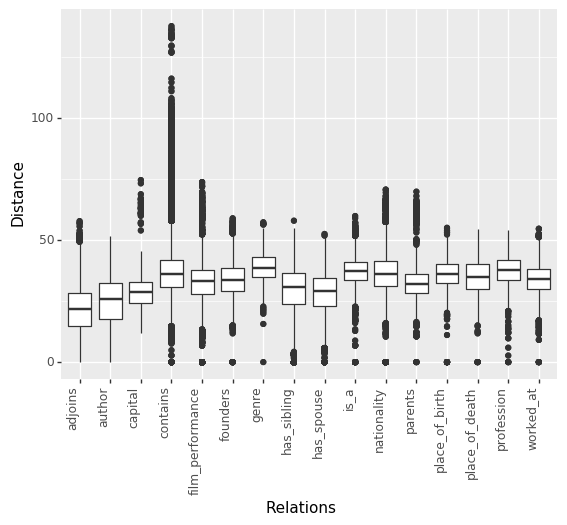

<ggplot: (-9223363296284378750)>

In [38]:
(ggplot(df)
     + geom_boxplot(aes('Relations', 'Distance'))
) + theme(axis_text_x  = element_text(angle = 90, hjust = 1))

In [40]:
import ast

rel = list(map(lambda x : ast.literal_eval(x)[0], distances_between.keys()))
mean_distances_between = list(map(lambda x:distances_between[x], distances_between.keys()))

In [70]:
distances = []
rel = []
for relation in distances_between.keys():
    dist = to_list(distances_between[relation])
    distances.extend(dist)
    rel.extend([relation] * len(dist))

In [71]:
len(distances)

4584064

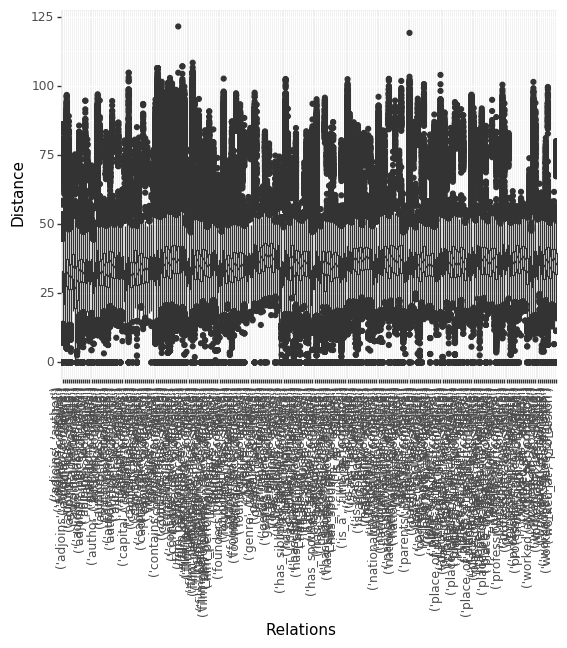

<ggplot: (-9223363296335977798)>

In [72]:
df_between = pd.DataFrame({'Distance': distances, 'Relations': rel})
(ggplot(df_between)
     + geom_boxplot(aes('Relations', 'Distance'))
) + theme(axis_text_x  = element_text(angle = 90, hjust = 1))

In [33]:
np.mean(mean_distances_between)

0.8893576114893184

In [24]:
mean_distances_within = list(map(lambda x:distances_within[x][0][0][0], distances_within.keys()))

In [34]:
np.mean(mean_distances_within)

0.00016987665114331918